# Lab 8 - Automatic Gradient Training Loop

Dominik Gaweł

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dg7s/Machine-Learning/blob/main/hw/Automatic_Gradient_Working_with_Other_Loss_Functions.ipynb)
-------------------------------

# **Homework Assignment: Working with Other Loss Functions**

-------------------------------

During the class today, we reconstructed an **ellipse**. The ellipse was defined with two **foci** and $C$ (the sum of distances of the ellipse points from the foci).

To reconstruct the ellipse through optimization, we began with **$N$ points** scattered randomly in the 2D plane. Our goal was to adjust their positions so that they satisfy the elliptical constraint as closely as possible. We achieved this by minimizing the **error-related loss**, $L^{(2)}_{\text{ellipse}}$ which was defined in today's class with $\ell_2$ norm as:

$$
L^{(2)}_{\text{ellipse}} = \frac{1}{N} \sum_{i=1}^{N} \epsilon_i^2
$$

where
$$
 \epsilon_i = d_{i1} + d_{i2} - C
$$
where $N$ is the number of points, and $d_{i1}, d_{i2}$ are their distances to the two foci.

In the homework assignment you will experiment with 3 other loss definitions based on some other possible norms.



1. $\ell_0$ norm resulting in
  $$
  L^{(0)}_{\text{ellipse}} = \frac{1}{N} \sum_{i=1}^{N} \mathbf{1}(\epsilon_i \neq 0)
  $$
  - If you actually succeed to code this loss function, the question for you to answer in relation to $L^{(0)}_{\text{ellipse}}$ is why the training is not progressing with passing epochs.
  - If you actually fail to code this loss function, the question for you to answer is to explain the failure and reason out theoretically, why the training would not be progressing with passing epochs, anyway.

1. $\ell_1$ norm resulting in
  $$
  L^{(1)}_{\text{ellipse}} = \frac{1}{N} \sum_{i=1}^{N} |\epsilon_i|
  $$
  The question for you to answer in relation to $L^{(1)}_{\text{ellipse}}$ is why the training loss doesn't converge, even after the ellipse has been fully drawn.

1. $\ell_\infty$ norm resulting in
  $$
  L^{(\infty)}_{\text{ellipse}} =  \max_{i} |\epsilon_i|
  $$
  The question for you to answer in relation to $L^{(\infty)}_{\text{ellipse}}$ is why the training takes so long and it doesn't converge in the end, either.

## **Points to Note**

1. Draw both the shape that the points draw as they move, and the loss value after each epoch, just as we did in class today.

2. Note, that the purpose of this excercise is not that you reconstruct a perfect ellipse, but rather that you give it a try, and even if you fail you should document and explain the failure, and answer a question related to a given loss definition.

3. You can also play around with the learning rate to try to improve convergence.

## **Task & Deliverables**
  
   - Document your experiments (python code and charts) and **write down your conclusions** into the Colab notebook.
   - It is not strictly required, but **if you make a movie showing the optimization progress it will be considered a strong point of your solution**
     - You can make a movie programmatically as we did in clustering class (our second class) with EM clustering,
     - or, you can save to disk the image files with epoch charts and use an external tool to bind them into a movie. Provide links to movie files in the README.
   - Place the Colab notebook  with the solution in your **GitHub repository** for this course.
   - In your repository’s **README**, add a **link** to the notebook (and any movies you created) and also include an **“Open in Colab”** badge at the top of the notebook so it can be launched directly from GitHub.


In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import time
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Fix the random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Define ellipse parameters
focus1 = torch.tensor([-2.0, 0.0])
focus2 = torch.tensor([2.0, 0.0])
constant_sum = 6.0

# Initialize random 2D points from uniform distribution
num_points = 100
num_epochs = 1000
lr = 0.1

def create_norm_animation(norm_type):
    points = torch.rand((num_points, 2)) * 10 - 5
    points.requires_grad = True
    optimizer = torch.optim.Adam([points], lr=lr)

    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Initialize plots
    scatter = ax1.scatter([], [], c='b', alpha=0.5)
    foci_plot = ax1.scatter([focus1[0], focus2[0]],
                          [focus1[1], focus2[1]],
                          c='red', s=100, marker='*')
    loss_line, = ax2.plot([], [], 'r-')

    # Configure axes
    ax1.set_xlim(-6, 6); ax1.set_ylim(-6, 6)
    ax1.set_title('Point Positions')
    ax2.set_yscale('log')
    ax2.set_title(f'{norm_type.upper()} Loss Evolution')
    ax2.set_xlabel('Epoch'); ax2.set_ylabel('Loss')

    loss_history = []
    start_time = time.time()

    def animate(frame):
        optimizer.zero_grad()
        dist1 = torch.norm(points - focus1, dim=1)
        dist2 = torch.norm(points - focus2, dim=1)
        epsilon = dist1 + dist2 - constant_sum

        if norm_type == 'l0':
            loss = torch.mean((epsilon != 0).float())
        elif norm_type == 'l1':
            loss = torch.mean(torch.abs(epsilon))
        elif norm_type == 'linf':
            loss = torch.max(torch.abs(epsilon))

        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())

        # Update plots
        scatter.set_offsets(points.detach().numpy())
        loss_line.set_data(np.arange(len(loss_history)), loss_history)
        ax2.relim()
        ax2.autoscale_view()

        if frame == num_epochs - 1:
            print(f"Training time: {time.time()-start_time:.2f}s")

        return scatter, loss_line

    anim = FuncAnimation(fig, animate, frames=num_epochs, interval=20, blit=True)
    plt.close()
    return anim

### 1. $\ell_0$ Loss  

Starting L0 training...


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

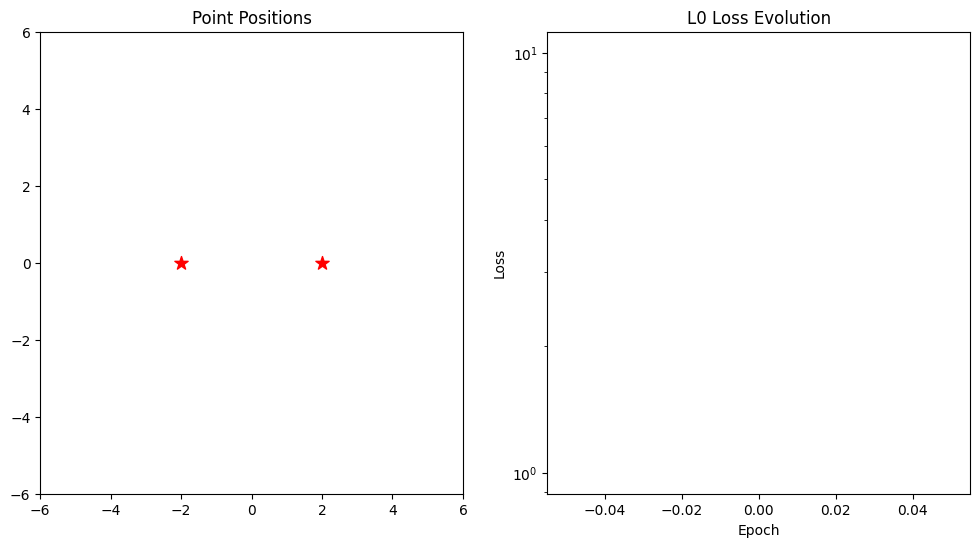

In [ ]:
print("Starting L0 training...")
l0_anim = create_norm_animation('l0')
HTML(l0_anim.to_html5_video())

**Runtime error in PyTorch:**  
```text
RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn
```
This happens because
```python
loss = torch.mean((epsilon != 0).float())
```
creates a tensor with `requires_grad=False`. The indicator function $\mathbb{1}(\epsilon_i\neq 0)$ has **zero gradients** everywhere, except at $\epsilon_i = 0$, where it's undefined.


- The indicator is non‑differentiable; there is no gradient information to adjust any point.

- Even if we coded a “straight‑through” estimator, we’d get almost no signal. Only points exactly on the ellipse $\epsilon_i=0$ could theoretically contribute gradients, but this occurs with probability zero in continuous optimization.

### 1. $\ell_1$ Loss  

In [ ]:
print("Starting L1 training...")
l1_anim = create_norm_animation('l1')
HTML(l1_anim.to_html5_video())

Starting L1 training...
Training time: 144.27s


Loss drops quickly at first, but even after points visually trace out the ellipse, the loss curve keeps oscillating.

The derivation of $|\epsilon_i|$ is $\pm 1$, except zero, where we can use subgradient. Therefore, gradient remain **constant** and couses update to overshoot the minimum by a fixed step, even when points are near the ellipse. To see the convergence we should **anneal the learning rate**.

### 1. $\ell_{\infty}$ Loss  


In [ ]:
print("Starting Linf training...")
linf_anim = create_norm_animation('linf')
HTML(linf_anim.to_html5_video())

Starting Linf training...
Training time: 129.28s


The $\ell_{\infty}$ loss may causes slow training as only the single worst‐error point receives a nonzero gradient each step; all other points see zero, so we move only one point per iteration. Moreover, the gradient for the max‐norm is $\pm 1$ at the worst index, causing that point to overshoot its optimum by a fixed step. As soon as another point becomes worst, we switch and overshoot again. Frequent switches in which point has the highest error prevent the maximum error from steadily decreasing to zero.
